# Using Binary Annotations

This notebook contains snippets for working with binary annotations and non-standard folder structures.

The `requests` module is a Python web client. Confirm its installed

!pip3 install requests

Download the LabelMe-12-50K data set.

In [6]:
import requests
import os

download_file = 'https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz'
local_file = os.path.join('data',os.path.basename(download_file))
if not os.path.exists('data'):
    os.mkdir('data')

r = requests.get(download_file)
with open(local_file, 'wb') as f:
    f.write(r.content)

Extract the **.targ.gz** file into the `./raw/` folder

In [7]:
import tarfile
with tarfile.open(local_file) as f:
    f.extractall('raw')

Define an `Enum` class for making the numeric label values human-friendly.

In [67]:
from enum import Enum
class Label(Enum):    
    NONE=0
    PERSON=1
    CAR=2
    BUILDING=3
    WINDOW=4
    TREE=5
    SIGN=6
    DOOR=7
    BOOKSHELF=8
    CHAIR=9
    TABLE=10
    KEYBOARD=11
    HEAD=12
    CLUTTER= 13


The `read_annotations` function parses the binary file and produces `Annotation` objects.

In [12]:
import struct
SIZE_UINT = 4
LABEL_COUNT = 12

def read_annotations(dataset):
    annotations = []
    index = 0
    with open('./raw/%s/annotation.bin' % dataset,'rb') as f:
        data = f.read()
        for offset in range(0,len(data), LABEL_COUNT * SIZE_UINT):        
            chunk = data[offset:offset+LABEL_COUNT * SIZE_UINT]
            label_values = struct.unpack('f'*LABEL_COUNT,chunk)

            annotation = Annotation(index,label_values)
            annotations.append(annotation)
            index += 1
    return annotations

The `Annotation` class is a simple wrapper around the image metadata.

In [118]:
class Annotation:
    def __init__(self, index, label_values) -> None:
        self.__index= index
        self.__values = label_values

    @property
    def index(self):
        return self.__index
        
    @property
    def label(self):
        return self.__get_label()

    @property
    def values(self):
        return self.__values

    @property
    def file_name(self):
        file= str(self.__index).zfill(6)
        dir = str(int(self.index / 1000)).zfill(4)
        return os.path.join(dir,file+'.jpg')

    def __get_label(self):
        value = 1
        for x in self.__values:
            if not x == 1:
                value += 1
                continue
            else:
                break
        return Label(value)


Read the `test` and `train` datasets `annotations.bin` files.

In [119]:
test_annotations = read_annotations('test')
train_annotations = read_annotations('train')

The `confirm_annotations` function counts the labels as a simple verification that results are as expected.

In [23]:
def confirm_annotations(annotations):
    counts = {}
    for ann in annotations:    
        if not ann.label.value in counts:
            counts[ann.label.value] =1
        else:
            counts[ann.label.value] +=1

    keys = sorted(list(counts.keys()))
    for key in keys:
        print('[%s] %d' % (Label(key),  counts[key]))   

print('Training Set\n%s' % ('='*12))
confirm_annotations(train_annotations)
print('Test Set\n%s' % ('='*12))
confirm_annotations(test_annotations)

Training Set
[Label.PERSON] 4856
[Label.CAR] 3830
[Label.BUILDING] 2085
[Label.WINDOW] 4098
[Label.TREE] 1846
[Label.SIGN] 951
[Label.DOOR] 830
[Label.BOOKSHELF] 391
[Label.CHAIR] 385
[Label.TABLE] 192
[Label.KEYBOARD] 324
[Label.HEAD] 212
[Label.CLUTTER] 20000
Test Set
[Label.PERSON] 1180
[Label.CAR] 974
[Label.BUILDING] 531
[Label.WINDOW] 1028
[Label.TREE] 494
[Label.SIGN] 249
[Label.DOOR] 178
[Label.BOOKSHELF] 100
[Label.CHAIR] 88
[Label.TABLE] 54
[Label.KEYBOARD] 75
[Label.HEAD] 49
[Label.CLUTTER] 5000


This snippet using filesystem linking to efficiently restructure the files as `./data/DATASET/LABEL/file.jpg`.

In [150]:
from os import symlink, path, mkdir, link, remove
MAX_LABEL_VALUE=13

for ds, annotations in [('train', train_annotations),('test', test_annotations)]:
    in_dir = './raw/%s' % ds
    out_dir = './%s' % ds
    if not path.exists(out_dir):
        mkdir(out_dir)

    for ix in range(0,MAX_LABEL_VALUE+1):
        label = Label(ix).name
        subdir = path.join(out_dir, label)
        if not path.exists(subdir):
            mkdir(subdir)

    for ann in annotations:
        src = path.join(in_dir,ann.file_name)
        dst = path.join(out_dir, ann.label.name, path.basename(ann.file_name))
        if path.exists(dst):        
            os.remove(dst)
        #print('%s -> %s' % (src,dst))
        link(src,dst)

You can confirm this approach works as expected by displaying one of the files.

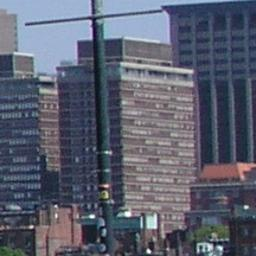

In [80]:
from IPython.display import Image
Image(filename='./training/BUILDING/000002.jpg')

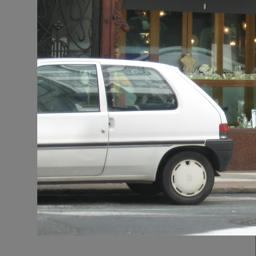

In [70]:
Image(filename='./train-tree/CAR/000003.jpg')

One of the advantages of reshuffling the files into this folder structure is the simplicity to load them. Lets observe this behavior for TensorFlow.

In [93]:
!pip3 install tensorflow

Next let's import the Keras interface

In [94]:
from tensorflow import keras

2023-02-05 00:46:55.973149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 00:46:56.217457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 00:46:56.217478: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 00:46:57.703897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Keras has numerous utility functions that reduce the complexity of dealing with TensorFlow. Let's use its `image_dataset_from_directory` to efficiently load the files in batches with common preprocessing steps already performed.

In [152]:
import tensorflow as tf
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train/',
    labels='inferred',
    label_mode='int',    
    color_mode='grayscale',
    image_size=(256,256),
    follow_links=True,
    seed=0)

testing_images = tf.keras.preprocessing.image_dataset_from_directory(
    './data/test/',
    labels='inferred',
    label_mode='int',    
    color_mode='grayscale',
    image_size=(256,256),
    follow_links=True,
    seed=0)

Found 40000 files belonging to 14 classes.
Found 10000 files belonging to 14 classes.


Next, let's install the `matplotlib` module for rendering a 3x3 plot of the imported images. 

In [137]:
!pip3 install matplotlib

     |████████████████████████████████| 11.8 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 48.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 28.6 MB/s eta 0:00:01


Use `pyplot` to render the `figure`.

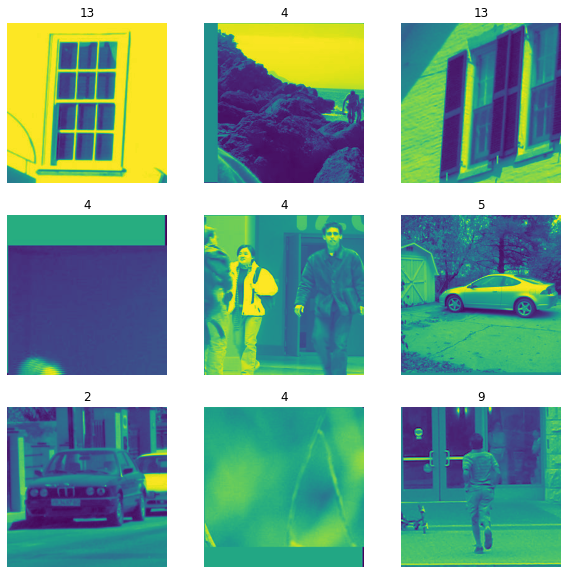

In [141]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")